# Dates and Times

A special type of categorical variable are those that instead of taking traditional labels, like color (blue, red), or city (London, Manchester), take dates and / or time as values. For example, date of birth ('29-08-1987', '12-01-2012'), or date of application ('2016-Dec', '2013-March').

Datetime variables can contain dates only, time only, or date and time.

We don't usually work with a datetime variable in their raw format because:

- Date variables contain a huge number of different categories
- We can extract much more information from datetime variables by preprocessing them correctly

In addition, often, date variables will contain dates that were not present in the dataset used to train the machine learning model. In fact, date variables will usually contain dates placed in the future, respect to the dates in the training dataset. Therefore, the machine learning model will not know what to do with them, because it never saw them while being trained. 

# Basic Imports

In [1]:
# this is specific to macos X , windows/linux users dont need this 
# without this , while using xgboost , you get errors , kernel dies
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import math as mt

In [4]:
# !pip install rfpimp

In [5]:
from rfpimp import *
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

# Load Data

In [6]:
# Variable definitions:
#-------------------------
# disbursed amount: loan amount lent to the borrower
# market: risk band in which borrowers are placed
# loan purpose: intended use of the loan
# date_issued: date the loan was issued
# date_last_payment: date of last payment towards repyaing the loan

file = r'./data/loan.csv'
data=pd.read_csv(file)

In [7]:
data.shape

(10000, 14)

In [8]:
data.sample(5)

,customer_id,disbursed_amount,interest,market,employment,time_employed,householder,income,date_issued,target,loan_purpose,number_open_accounts,date_last_payment,number_credit_lines_12
3082,3082,940.0,18.0675,E,NaN,NaN,RENT,10431.12,2015-10-13,0,Other,15.0,2016-01-08,NaN
5886,5886,9200.0,7.4676,A,Bus driver,>5 years,MORTGAGE,72960.00,2013-07-15,0,Home improvements,14.0,2016-01-20,NaN
6660,6660,19000.0,13.2446,B,Statistician,<=5 years,MORTGAGE,54450.00,2012-07-06,0,Debt consolidation,12.0,2015-07-22,NaN
1009,1009,22770.0,16.4312,D,Dentist,<=5 years,MORTGAGE,147200.00,2015-09-02,0,Debt consolidation,11.0,2016-01-01,NaN
4650,4650,23760.0,14.7108,D,Dentist,>5 years,MORTGAGE,58200.00,2011-06-13,0,Debt consolidation,13.0,2013-03-07,NaN


In [9]:
# pandas assigns type 'object' when reading dates
# and considers them strings.
# Let's have a look

data[['date_issued', 'date_last_payment']].dtypes

date_issued          object
date_last_payment    object
dtype: object

Both date_issued and date_last_payment are casted as objects. Therefore, pandas will treat them as strings or categorical variables.

In order to instruct pandas to treat them as dates, we need to re-cast them into datetime format:

# Datetime Conversions and Analysis

In [10]:
# now let's parse the dates, currently coded as strings, into datetime format
# this will allow us to make some analysis afterwards

data['issued_dt'] = pd.to_datetime(data['date_issued'])
data['last_payment_dt'] = pd.to_datetime(data['date_last_payment'])

In [11]:
data.shape

(10000, 16)

In [12]:
data[['date_issued', 'issued_dt', 'date_last_payment', 'last_payment_dt']].head()

,date_issued,issued_dt,date_last_payment,last_payment_dt
0,2013-06-11,2013-06-11,2016-01-14,2016-01-14
1,2014-05-08,2014-05-08,2016-01-25,2016-01-25
2,2013-10-26,2013-10-26,2014-09-26,2014-09-26
3,2015-08-20,2015-08-20,2016-01-26,2016-01-26
4,2014-07-22,2014-07-22,2016-01-11,2016-01-11


In [13]:
data[['date_issued', 'issued_dt', 'date_last_payment', 'last_payment_dt']].dtypes

date_issued                  object
issued_dt            datetime64[ns]
date_last_payment            object
last_payment_dt      datetime64[ns]
dtype: object

In [57]:
# let's extract the month and the year from the variable date
# to make nicer plots

data['month'] = data['issued_dt'].dt.month
data['year'] = data['issued_dt'].dt.year

In [17]:
data['month'].unique()

array([ 6,  5, 10,  8,  7,  9,  3,  2, 12, 11,  4,  1])

In [19]:
data['year'].unique()

array([2013, 2014, 2015, 2011, 2009, 2012, 2010, 2008, 2007])

In [20]:
data.groupby(['year', 'month', 'market'])['disbursed_amount'].sum().unstack()

market               A           B           C           D           E
year month                                                            
2007 7         1820.00         NaN         NaN         NaN         NaN
     8             NaN         NaN         NaN         NaN    18600.00
     9             NaN         NaN         NaN         NaN    19432.25
     10            NaN         NaN         NaN         NaN    14256.00
     12            NaN     2796.50         NaN         NaN         NaN
...                ...         ...         ...         ...         ...
2015 8      1149909.75  1536688.75  1491727.50   880038.75   852688.00
     9       757929.75  1287596.50  1386275.50   879593.25   686892.25
     10      971295.50  2361789.00  2243754.50  1080193.75  1112724.25
     11      998115.50  1679571.50  2017138.00   858076.25   542300.00
     12     1094781.50  1775188.00  1941545.75  1083162.50   871467.50

[99 rows x 5 columns]

In [21]:
data.groupby(['year', 'month', 'market'])['disbursed_amount'].sum().unstack().head()

market           A       B   C   D         E
year month                                  
2007 7      1820.0     NaN NaN NaN       NaN
     8         NaN     NaN NaN NaN  18600.00
     9         NaN     NaN NaN NaN  19432.25
     10        NaN     NaN NaN NaN  14256.00
     12        NaN  2796.5 NaN NaN       NaN

Text(0, 0.5, 'Disbursed Amount')

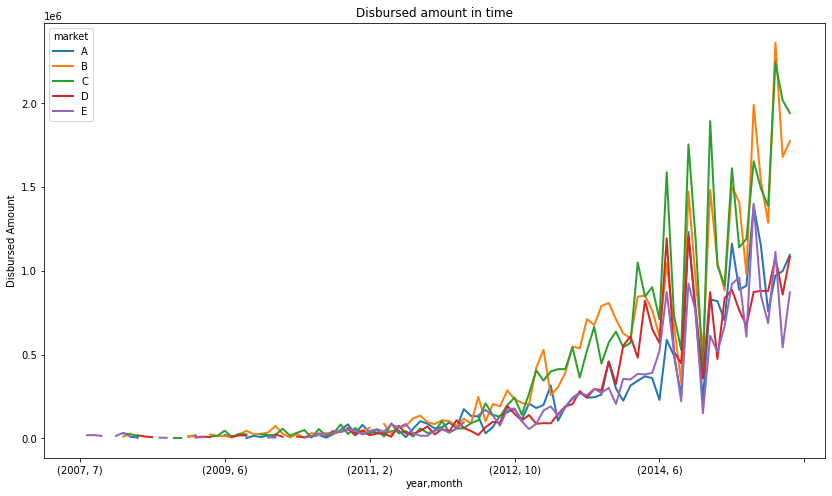

In [22]:
# let's see how much money Lending has disbursed
# (i.e., lent) over the years to the different risk
# markets (grade variable)

fig = data.groupby(['year','month', 'market'])['disbursed_amount'].sum().unstack().plot(
    figsize=(14, 8), linewidth=2)

fig.set_title('Disbursed amount in time')
fig.set_ylabel('Disbursed Amount')

This toy finance company seems to have increased the amount of money lent from 2012 onwards. The tendency indicates that they continue to grow. In addition, we can see that their major business comes from lending money to C and B grades.

'A' grades are the lower risk borrowers, borrowers that most likely will be able to repay their loans, as they are typically in a better financial situation. Borrowers within this grade are charged lower interest rates.

D and E grades represent the riskier borrowers. Usually borrowers in somewhat tighter financial situations, or for whom there is not sufficient financial history to make a reliable credit assessment. They are typically charged higher rates, as the business, and therefore the investors, take a higher risk when lending them money.

# Coding cyclic time features 

In [58]:
data['month'].unique()

array([ 6,  5, 10,  8,  7,  9,  3,  2, 12, 11,  4,  1])

In [59]:
# month=12=2pi i.e. 360
# 360/12 = 30
# month =1=(pi/6) = 30deg
months_sin=np.sin(2*np.pi*data['month']/12) 

[]

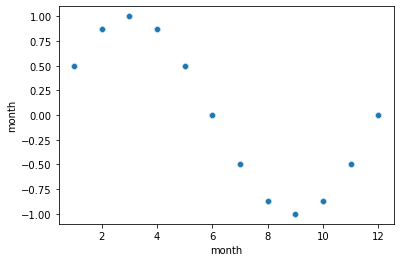

In [24]:
sns.scatterplot(data['month'], months_sin).plot()

In [ ]:
months_sin

In [25]:
months_cos=np.cos(2*np.pi*data['month']/12)

[]

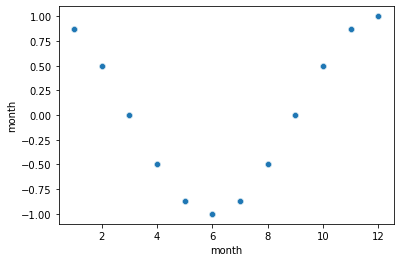

In [26]:
sns.scatterplot(data['month'], months_cos).plot()

In [ ]:
months_sin

In [ ]:
months_cos

[]

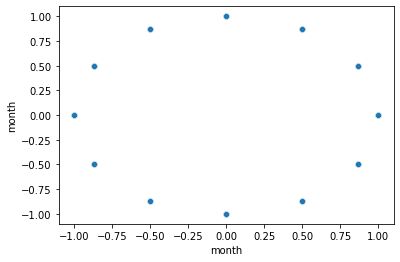

In [27]:
sns.scatterplot(months_sin, months_cos).plot()

In [28]:
def code_cyclic_features(data,columns,drop_cols=True):
    for col in columns:
        max_val=max(data[col])

        data[col+'_sin']=np.sin(2*np.pi*data[col]/max_val)
        data[col+'_cos']=np.cos(2*np.pi*data[col]/max_val)

        if drop_cols:
            del data[col]
    return data  

In [29]:
code_cyclic_features(data, ['month'])

,customer_id,disbursed_amount,interest,market,employment,time_employed,householder,income,date_issued,target,loan_purpose,number_open_accounts,date_last_payment,number_credit_lines_12,issued_dt,last_payment_dt,year,month_sin,month_cos
0,0,23201.5,15.4840,C,Teacher,<=5 years,RENT,84600.0,2013-06-11,0,Debt consolidation,4.0,2016-01-14,NaN,2013-06-11,2016-01-14,2013,1.224647e-16,-1.000000e+00
1,1,7425.0,11.2032,B,Accountant,<=5 years,OWNER,102000.0,2014-05-08,0,Car purchase,13.0,2016-01-25,NaN,2014-05-08,2016-01-25,2014,5.000000e-01,-8.660254e-01
2,2,11150.0,8.5100,A,Statistician,<=5 years,RENT,69840.0,2013-10-26,0,Debt consolidation,8.0,2014-09-26,NaN,2013-10-26,2014-09-26,2013,-8.660254e-01,5.000000e-01
3,3,7600.0,5.8656,A,Other,<=5 years,RENT,100386.0,2015-08-20,0,Debt consolidation,20.0,2016-01-26,NaN,2015-08-20,2016-01-26,2015,-8.660254e-01,-5.000000e-01
4,4,31960.0,18.7392,E,Bus driver,>5 years,RENT,95040.0,2014-07-22,0,Debt consolidation,14.0,2016-01-11,NaN,2014-07-22,2016-01-11,2014,-5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,23750.0,11.0019,B,Civil Servant,<=5 years,MORTGAGE,98000.0,2010-01-14,0,Other,12.0,2010-11-03,NaN,2010-01-14,2010-11-03,2010,5.000000e-01,8.660254e-01
9996,9996,11880.0,10.4923,B,Civil Servant,<=5 years,RENT,36270.0,2015-03-20,0,Debt consolidation,17.0,2016-01-26,NaN,2015-03-20,2016-01-26,2015,1.000000e+00,6.123234e-17
9997,9997,19950.0,8.4364,B,Accountant,>5 years,OWNER,52250.0,2015-04-03,0,Debt consolidation,9.0,2015-12-12,NaN,2015-04-03,2015-12-12,2015,8.660254e-01,-5.000000e-01
9998,9998,4850.0,13.6409,C,Bus driver,>5 years,RENT,80040.0,2014-11-23,0,Debt consolidation,26.0,2016-01-01,NaN,2014-11-23,2016-01-01,2014,-5.000000e-01,8.660254e-01


# Engineering Dates

Date variables are special type of categorical variable. By their own nature, date variables will contain a multitude of different labels, each one corresponding to a specific date and sometimes time. Date variables, when preprocessed properly can highly enrich a dataset. For example, from a date variable we can extract:

- Week of the year
- Month
- Quarter
- Semester
- Year
- Day (number)
- Day of the week
- Is Weekend?
- Time differences in years, months, days, hrs, etc.

Date variables should not be used as categorical variables when building a machine learning model. Not only because they have a multitude of categories, but also because when we actually use the model to score a new observation, this observation will most likely be in the future, an therefore its date label, might be different from the ones contained in the training set and therefore the ones used to train the machine learning algorithm.

In [30]:
import pandas as pd
import numpy as np

import datetime

In [31]:
data.head()

,customer_id,disbursed_amount,interest,market,employment,time_employed,householder,income,date_issued,target,loan_purpose,number_open_accounts,date_last_payment,number_credit_lines_12,issued_dt,last_payment_dt,year,month_sin,month_cos
0,0,23201.5,15.4840,C,Teacher,<=5 years,RENT,84600.0,2013-06-11,0,Debt consolidation,4.0,2016-01-14,NaN,2013-06-11,2016-01-14,2013,1.224647e-16,-1.000000
1,1,7425.0,11.2032,B,Accountant,<=5 years,OWNER,102000.0,2014-05-08,0,Car purchase,13.0,2016-01-25,NaN,2014-05-08,2016-01-25,2014,5.000000e-01,-0.866025
2,2,11150.0,8.5100,A,Statistician,<=5 years,RENT,69840.0,2013-10-26,0,Debt consolidation,8.0,2014-09-26,NaN,2013-10-26,2014-09-26,2013,-8.660254e-01,0.500000
3,3,7600.0,5.8656,A,Other,<=5 years,RENT,100386.0,2015-08-20,0,Debt consolidation,20.0,2016-01-26,NaN,2015-08-20,2016-01-26,2015,-8.660254e-01,-0.500000
4,4,31960.0,18.7392,E,Bus driver,>5 years,RENT,95040.0,2014-07-22,0,Debt consolidation,14.0,2016-01-11,NaN,2014-07-22,2016-01-11,2014,-5.000000e-01,-0.866025


In [32]:
# now let's parse the dates, currently cast as strings, into datetime format
data[['date_issued','issued_dt','date_last_payment', 'last_payment_dt']].head()

,date_issued,issued_dt,date_last_payment,last_payment_dt
0,2013-06-11,2013-06-11,2016-01-14,2016-01-14
1,2014-05-08,2014-05-08,2016-01-25,2016-01-25
2,2013-10-26,2013-10-26,2014-09-26,2014-09-26
3,2015-08-20,2015-08-20,2016-01-26,2016-01-26
4,2014-07-22,2014-07-22,2016-01-11,2016-01-11


## Extract week of the year

In [33]:
# Extracting week of year from date, varies from 1 to 52

data['issued_dt_week'] = data['issued_dt'].dt.week

data[['issued_dt', 'issued_dt_week']].head()

,issued_dt,issued_dt_week
0,2013-06-11,24
1,2014-05-08,19
2,2013-10-26,43
3,2015-08-20,34
4,2014-07-22,30


In [34]:
data['issued_dt_week'].unique()

array([24, 19, 43, 34, 30, 39, 12,  7, 52, 47, 14, 44, 46, 17,  8,  2, 25,
       51, 15, 11, 36, 21, 16, 49, 23,  6, 40, 29, 38, 33, 27, 28, 41, 20,
       50,  9,  5, 32, 45, 10, 42, 48,  4,  1, 26, 13, 37,  3, 22, 35, 18,
       31])

## Extract month

In [35]:
# Extracting month from date - 1 to 12

data['issued_dt_month'] = data['issued_dt'].dt.month

data[['issued_dt', 'issued_dt_month']].head()

,issued_dt,issued_dt_month
0,2013-06-11,6
1,2014-05-08,5
2,2013-10-26,10
3,2015-08-20,8
4,2014-07-22,7


In [36]:
data['issued_dt_month'].unique()

array([ 6,  5, 10,  8,  7,  9,  3,  2, 12, 11,  4,  1])

## Extract quarter

In [37]:
# Extract quarter from date variable - 1 to 4

data['issued_dt_quarter'] = data['issued_dt'].dt.quarter

data[['issued_dt', 'issued_dt_quarter']].head()

,issued_dt,issued_dt_quarter
0,2013-06-11,2
1,2014-05-08,2
2,2013-10-26,4
3,2015-08-20,3
4,2014-07-22,3


In [38]:
data['issued_dt_quarter'].unique()

array([2, 4, 3, 1])

## Extract semester

In [39]:
# We could also extract semester
data['issued_dt_semester'] = np.where(data['issued_dt_quarter'].isin([1,2]), 1, 2)
data.head()

,customer_id,disbursed_amount,interest,market,employment,time_employed,householder,income,date_issued,target,...,number_credit_lines_12,issued_dt,last_payment_dt,year,month_sin,month_cos,issued_dt_week,issued_dt_month,issued_dt_quarter,issued_dt_semester
0,0,23201.5,15.4840,C,Teacher,<=5 years,RENT,84600.0,2013-06-11,0,...,NaN,2013-06-11,2016-01-14,2013,1.224647e-16,-1.000000,24,6,2,1
1,1,7425.0,11.2032,B,Accountant,<=5 years,OWNER,102000.0,2014-05-08,0,...,NaN,2014-05-08,2016-01-25,2014,5.000000e-01,-0.866025,19,5,2,1
2,2,11150.0,8.5100,A,Statistician,<=5 years,RENT,69840.0,2013-10-26,0,...,NaN,2013-10-26,2014-09-26,2013,-8.660254e-01,0.500000,43,10,4,2
3,3,7600.0,5.8656,A,Other,<=5 years,RENT,100386.0,2015-08-20,0,...,NaN,2015-08-20,2016-01-26,2015,-8.660254e-01,-0.500000,34,8,3,2
4,4,31960.0,18.7392,E,Bus driver,>5 years,RENT,95040.0,2014-07-22,0,...,NaN,2014-07-22,2016-01-11,2014,-5.000000e-01,-0.866025,30,7,3,2


In [40]:
data['issued_dt_semester'].unique()

array([1, 2])

##  Extract year

In [41]:
# extract year 
data['issued_dt_year'] = data['issued_dt'].dt.year
data[['issued_dt', 'issued_dt_year']].head()

,issued_dt,issued_dt_year
0,2013-06-11,2013
1,2014-05-08,2014
2,2013-10-26,2013
3,2015-08-20,2015
4,2014-07-22,2014


In [42]:
data['issued_dt_year'].unique()

array([2013, 2014, 2015, 2011, 2009, 2012, 2010, 2008, 2007])

## Extract days, in various formats

In [43]:
# day - numeric from 1-31
data['issued_dt_day'] = data['issued_dt'].dt.day

data[['issued_dt', 'issued_dt_day']].head()

,issued_dt,issued_dt_day
0,2013-06-11,11
1,2014-05-08,8
2,2013-10-26,26
3,2015-08-20,20
4,2014-07-22,22


In [44]:
data['issued_dt_day'].unique()

array([11,  8, 26, 20, 22, 21, 27, 14, 25,  4, 13, 23, 19, 18, 24, 17,  6,
        1, 12, 10,  5,  3,  7,  2,  9, 16, 15])

In [45]:
# day of the week - from 0 to 6
data['issued_dt_dayofweek'] = data['issued_dt'].dt.dayofweek
data[['issued_dt', 'issued_dt_dayofweek']].head()

,issued_dt,issued_dt_dayofweek
0,2013-06-11,1
1,2014-05-08,3
2,2013-10-26,5
3,2015-08-20,3
4,2014-07-22,1


In [46]:
data['issued_dt_dayofweek'].unique()

array([1, 3, 5, 2, 6, 4, 0])

In [47]:
# day of the week - name
data['issued_dt_dayofweek'] = data['issued_dt'].dt.day_name()
data[['issued_dt', 'issued_dt_dayofweek']].head()

,issued_dt,issued_dt_dayofweek
0,2013-06-11,Tuesday
1,2014-05-08,Thursday
2,2013-10-26,Saturday
3,2015-08-20,Thursday
4,2014-07-22,Tuesday


In [48]:
data['issued_dt_dayofweek'].unique()

array(['Tuesday', 'Thursday', 'Saturday', 'Wednesday', 'Sunday', 'Friday',
       'Monday'], dtype=object)

In [49]:
# was the application done on the weekend?

data['issued_dt_is_weekend'] = np.where(data['issued_dt_dayofweek'].isin(['Sunday', 'Saturday']), 1,0)
data[['issued_dt', 'issued_dt_dayofweek','issued_dt_is_weekend']].head()

,issued_dt,issued_dt_dayofweek,issued_dt_is_weekend
0,2013-06-11,Tuesday,0
1,2014-05-08,Thursday,0
2,2013-10-26,Saturday,1
3,2015-08-20,Thursday,0
4,2014-07-22,Tuesday,0


In [50]:
data['issued_dt_is_weekend'].unique()

array([0, 1])

## Extract Time elapsed between dates

In [51]:
# perhaps more interestingly, extract the date difference between 2 dates

data['issued_dt'] - data['last_payment_dt']

0      -947 days
1      -627 days
2      -335 days
3      -159 days
4      -538 days
          ...   
9995   -293 days
9996   -312 days
9997   -253 days
9998   -404 days
9999   -362 days
Length: 10000, dtype: timedelta64[ns]

In [53]:
# same as above capturing just the time difference

(data['last_payment_dt'] - data['issued_dt']).dt.days.head()

0    947
1    627
2    335
3    159
4    538
dtype: int64

In [54]:
# calculate number of months passed between 2 dates
# The date units are years (‘Y’), months (‘M’), weeks (‘W’), and days (‘D’), 
# while the time units are hours (‘h’), minutes (‘m’), seconds (‘s’), milliseconds (‘ms’)

data['months_passed'] = (data['last_payment_dt'] - data['issued_dt']) / np.timedelta64(1, 'M')
data['months_passed'] = np.round(data['months_passed'],0)

data[['last_payment_dt', 'issued_dt','months_passed']].head()

,last_payment_dt,issued_dt,months_passed
0,2016-01-14,2013-06-11,31.0
1,2016-01-25,2014-05-08,21.0
2,2014-09-26,2013-10-26,11.0
3,2016-01-26,2015-08-20,5.0
4,2016-01-11,2014-07-22,18.0
